# Imports

## Modules

In [ ]:
import os
import Unifoil_pipeline as unifoil
import Diffuser as diff
import Backbone
import torch
import numpy as np
from torch.optim import Adam
import Trainer as T
import tests
import OpenFoam_pipeline as prep

/mnt/ffp-data-repo/FoilDIff/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Variables and Settings 


In [2]:
#Settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs('./models2', exist_ok=True)
huge_loader, big_loader, small_loader = unifoil.get_and_load_dataset(batch_size=10, img_size=32)
image_size = 32
noise_steps = 200

epochs = 1000 # Try more!
def save_path(model_name):
    return f'./models2/{model_name}.pth'

#Models with presaved configs
CNNUnet = Backbone.UNET().to(device)
Unet = Backbone.UNET().to(device)
Tran = Backbone.DiT(input_size = image_size).to(device)
UNetTran = Backbone.Flex(size = image_size).to(device)
UViT = Backbone.UDiT(input_size = image_size).to(device)
UNetUViT = Backbone.UTFLEX(size = image_size).to(device)


Loading existing splits...
train: 28737, test: 8210, val: 4106


# Utils

In [3]:
combined_dataset, aux_train, aux_test, means, stds = prep.get_and_load_dataset()

Loading cached dataset statistics...
Train dataset: 330
Test dataset: 770
Combined dataset: 1100


In [4]:
def get_single_case(loader, n, q):
        for i, batch in enumerate(loader):
            if i == n:
                if q >= batch.shape[0]:
                    print(f"❌ Batch {n} contains only {batch.shape[0]} tensors. Cannot access tensor at index {q}.")
                    return
                tensor = batch[q]
                params = tensor[:3, :, :]  
                fl_field = tensor[ 3:, :, :]  
                unifoil.plot(tensor)
                return params, fl_field
        print(f"Batch index {n} is out of range.")
    

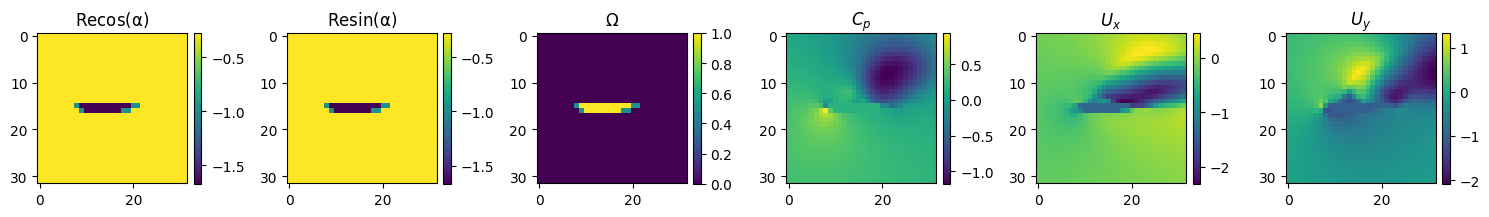

(tensor([[[-0.2743, -0.2743, -0.2743,  ..., -0.2743, -0.2743, -0.2743],
          [-0.2743, -0.2743, -0.2743,  ..., -0.2743, -0.2743, -0.2743],
          [-0.2743, -0.2743, -0.2743,  ..., -0.2743, -0.2743, -0.2743],
          ...,
          [-0.2743, -0.2743, -0.2743,  ..., -0.2743, -0.2743, -0.2743],
          [-0.2743, -0.2743, -0.2743,  ..., -0.2743, -0.2743, -0.2743],
          [-0.2743, -0.2743, -0.2743,  ..., -0.2743, -0.2743, -0.2743]],
 
         [[-0.2742, -0.2742, -0.2742,  ..., -0.2742, -0.2742, -0.2742],
          [-0.2742, -0.2742, -0.2742,  ..., -0.2742, -0.2742, -0.2742],
          [-0.2742, -0.2742, -0.2742,  ..., -0.2742, -0.2742, -0.2742],
          ...,
          [-0.2742, -0.2742, -0.2742,  ..., -0.2742, -0.2742, -0.2742],
          [-0.2742, -0.2742, -0.2742,  ..., -0.2742, -0.2742, -0.2742],
          [-0.2742, -0.2742, -0.2742,  ..., -0.2742, -0.2742, -0.2742]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,

In [5]:
get_single_case(aux_test, 2,1)

# Model Tests

# Train-Utils

In [7]:
def Diffusion_Train(save_path= save_path, predictor = None , loader = aux_test) :
    diffuser = diff.CosSchDiffuser(steps=noise_steps, device="cuda")
    # Adjust timesteps and device as needed
    trainer = T.Trainer(model=predictor, diffuser=diffuser, data_loader = loader, epochs= epochs, lr=1e-4, device=device, )
    # Start training
    Trained_model = trainer.train()
    path = str(save_path(predictor.__class__.__name__))

    Trained_model = Trained_model["last_model"]
    Optimizer =  trainer.optimizer.state_dict()
    # Save the model
    torch.save({
                    'model_state_dict': Trained_model.state_dict(),
                    'optimizer_state_dict': Optimizer,
                    }, path)
    print(f"Model saved to {path}")

    return Trained_model


# Train Models

In [8]:
FLex = Diffusion_Train(save_path, predictor = UNetTran )

Training:  35%|███▌      | 53900/154000 [2:41:37<5:18:19,  5.24it/s, loss=0.0125, lr=8.4e-5]   

Model checkpoint saved to ./checkpoints/UNetWithTransformer_epoch_350_TParam_e_loss_0.0191/model.pth


Training:  70%|███████   | 107801/154000 [5:19:04<9:40:27,  1.33it/s, loss=0.00421, lr=3.25e-5]

Model checkpoint saved to ./checkpoints/UNetWithTransformer_epoch_700_TParam_e_loss_0.0098/model.pth


Training: 100%|██████████| 154000/154000 [7:34:08<00:00,  5.07it/s, loss=0.00459, lr=1e-5]     

Training complete.
Model checkpoint saved to ./checkpoints/UNetWithTransformer_epoch_1000_TParam_e_loss_0.0072/model.pth


Training: 100%|██████████| 154000/154000 [7:34:14<00:00,  5.65it/s, loss=0.00459, lr=1e-5]

Model saved to ./models2/UNetWithTransformer.pth


# Test-Utils

In [6]:
def load_model(model_path = None, model_config = None,For_test = True, device=device, **kwargs):
    model =model_config
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    # Load the state dictionaries
    checkpoint = torch.load(model_path, map_location=device)
    print(f"Model loaded from {model_path}")
    if For_test:
        model.load_state_dict(checkpoint)
        model.eval()
        return model
    

    else:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        model.eval()
        return model , optimizer


       
   

    

In [7]:
#/mnt/ffp-data-repo/FoilDIff/checkpoints/UNetWithTransformer_epoch_1000_TParam_e_loss_0.0078/model.pth
New_model = load_model(model_path= "/mnt/ffp-data-repo/FoilDIff/checkpoints/UNetwithUViT_epoch_1000_TParam_e_loss_0.0118/model.pth",model_config=Backbone.UTFLEX(size = image_size), For_test =True)

Model loaded from /mnt/ffp-data-repo/FoilDIff/checkpoints/UNetwithUViT_epoch_1000_TParam_e_loss_0.0118/model.pth


In [8]:
def sample_diffusion(model,input_field,timestep=200,skip = 5, plot = False):
    model.eval();model.to(device)
    diffuser=diff.CosSchDiffuser(timestep,device=device)
    prediction=diffuser.sample_from_noise(model, input_field, show_progress= False, ddim=False, skip_steps= skip)
    if plot:
        unifoil.plot(prediction)
    return prediction

# Run Tests

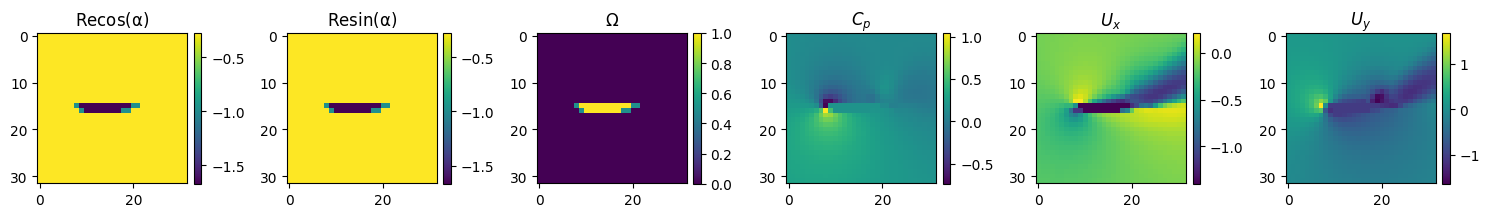

torch.Size([1, 3, 32, 32])

In [9]:
params,field = get_single_case(aux_test,1,1)
params.to(device)
params = params.unsqueeze(0).to(device)
params.shape

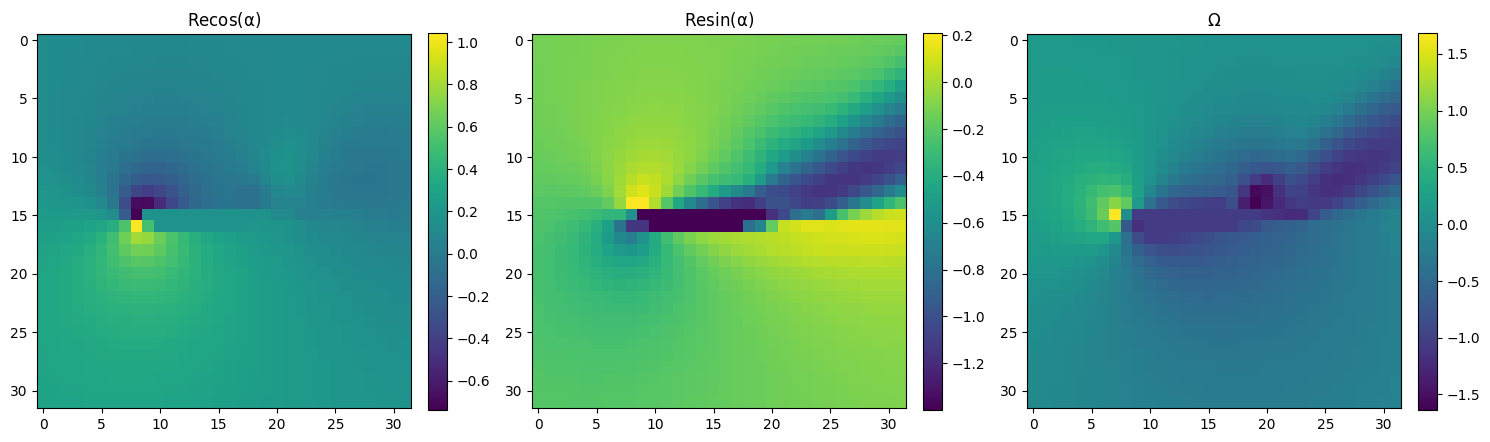

In [14]:
unifoil.plot(case=field,use="field")

## Test Model

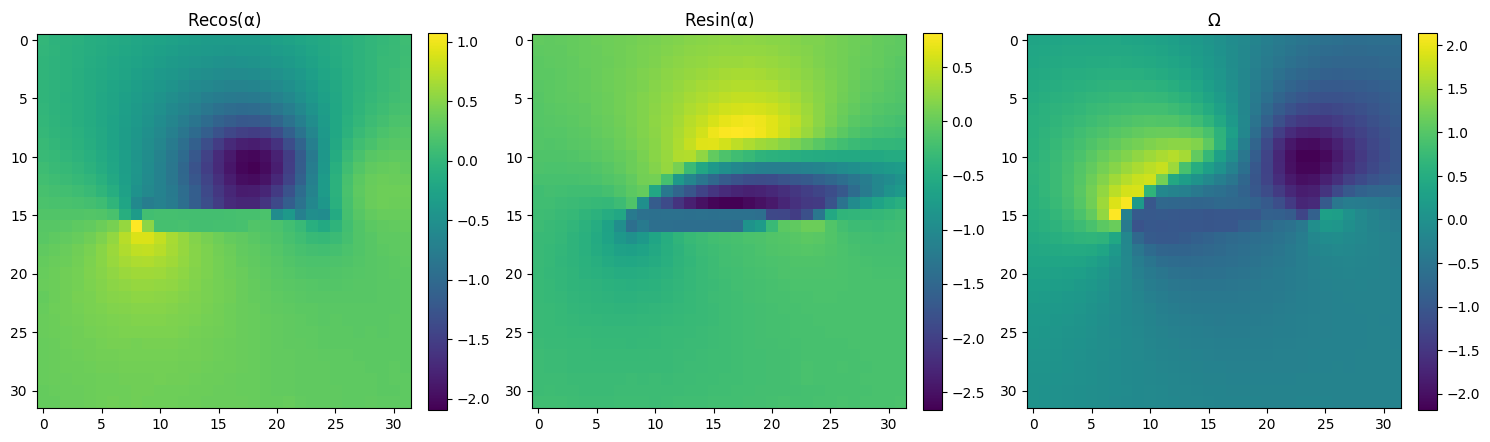

In [16]:
pred =sample_diffusion(model = New_model , input_field = params, plot=True)


# Post Process Results

In [17]:
error = field.to(device) - pred.to(device)
mse = torch.mean(error ** 2)
mse_per_channel = torch.mean(error ** 2, dim=(0, 2, 3)) 

mse_values = mse_per_channel.cpu().numpy()
print("MSE:", mse.item())
print("MSE per channel:", mse_values)

MSE: 0.21663427352905273
MSE per channel: [0.2620458  0.15078896 0.23706809]


In [23]:
def uncertainty_sample(model,input_field,timestep=200,skip = 5, plot = False, ddim = False,num_diffusion_sample=100):
    model.eval();model.to(device);predictions=[]
    batch_size=5;N_all=num_diffusion_sample
    diffuser=diff.CosSchDiffuser(timestep,device=device)
    while N_all>0:
        batch_size_now=min(batch_size,N_all)
        N_all-=batch_size
        prediction_batch=diffuser.sample_from_noise(model, input_field.repeat(batch_size_now,1,1,1), show_progress= False, ddim= ddim, skip_steps= skip)
        predictions.append(prediction_batch.detach().cpu().numpy())
    predictions=np.concatenate(predictions,axis=0)
    mean = torch.tensor(np.mean(predictions,axis=0))
    std = torch.tensor(np.std(predictions,axis=0))
    res = torch.cat([mean,std],dim=0 )
    if plot:
        unifoil.plot(res, use ="uncertainty")
    return res

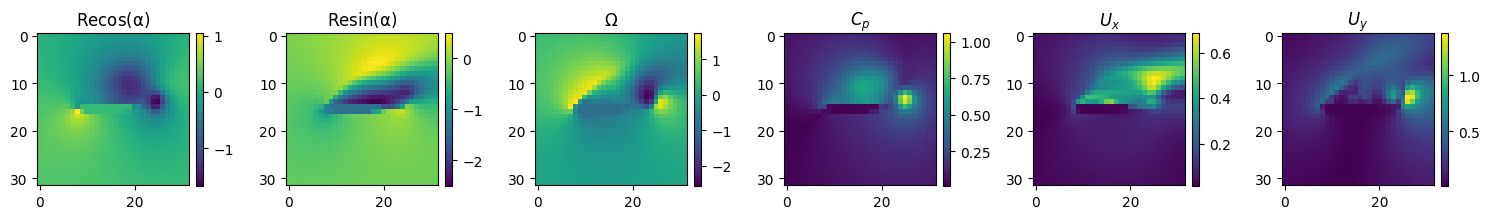

In [24]:
result = uncertainty_sample(model =New_model,input_field= params,timestep=200,skip = 5, plot = True, ddim = False,num_diffusion_sample=50)

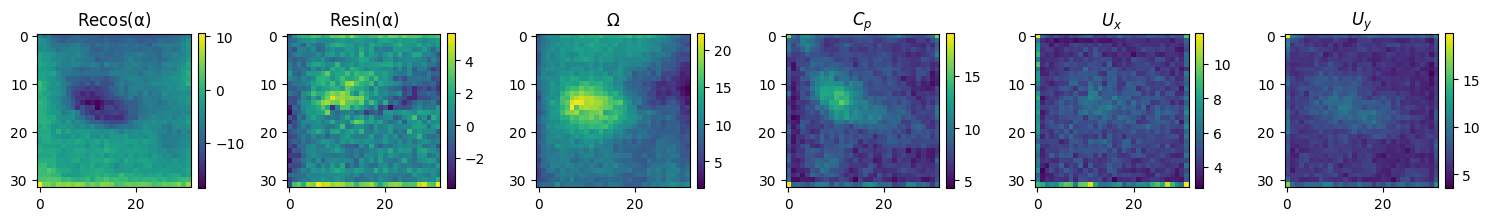

In [26]:
result = uncertainty_sample(model =New_model,input_field= params,timestep=200,skip = 1, plot = True, ddim = True,num_diffusion_sample=50)